# Machine Learning Models Applied to the IDS-2017

The purpose of this notebook is to experiment different machine learning on the IDS-2017 dataset generated by the CICFlowMeter on the recorder traffic which included benign and malicious flows

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
%matplotlib inline

file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"
import numpy as np

def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinity, or negative values
    invalid_columns = df[numeric_columns].columns[df[numeric_columns].isna().any() |
                                                  np.isinf(df[numeric_columns]).any() |
                                                  (df[numeric_columns] < 0).any()]

    print("Columns with NaN, infinity, or negative values:", invalid_columns.tolist())
    
    # Replace invalid values with NaN and fill with column mean
    df[invalid_columns] = df[invalid_columns].replace([np.inf, -np.inf, -1], np.nan)
    df[invalid_columns] = df[invalid_columns].fillna(df[invalid_columns].mean())
    
    return df
    
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    replace_invalid(df)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

# 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

Columns with NaN, infinity, or negative values: ['flow_duration', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_header_length_1', 'init_win_bytes_forward', 'init_win_bytes_backward', 'min_seg_size_forward']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                float64 
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]

# 2. Feature Selection

### Correlation based feature selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [4]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [5]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['destination_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 70 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  

### Remove collinear variables

In [6]:
threshold = 0.9
corr_matrix = X.corr().abs()
corr_matrix.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,1.000000,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,0.265288,1.000000,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,0.007272,0.020857,1.000000,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,0.006361,0.019669,0.999070,1.000000,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,0.033234,0.065456,0.365508,0.359451,1.000000,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [7]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,NaN,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,NaN,NaN,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,NaN,NaN,NaN,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,NaN,NaN,NaN,NaN,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,NaN,NaN,NaN,NaN,NaN,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [8]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_keep = [
    'Destination Port', 'Fwd Packet Length Std', 'Min Packet Length', 
    'Packet Length Variance', 'PSH Flag Count', 'Active Max'
]
to_drop = [column for column in to_drop if column not in to_keep]
print('There are %d columns to remove.' % (len(to_drop)))
X = X.drop(columns=to_drop)
X.info()

There are 31 columns to remove.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 39 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_min                 float64
 14  fwd_iat_min                  float64
 15  bwd_iat_total                float64
 16  bwd_iat_mean                 float64
 17  bwd_iat_std                  float64
 18  bwd_iat_ma

### 3. Split Dataset

The dataset is split into a train, cross-validation and evaluation sets with a ratio of 0.8/0.1/0.1. The dataset is stratified according to the label to have an equal representation of all classes in the 3 subsets.

In [9]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, stratify=Y.label)
X_eval, X_test, Y_eval, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp.label)

In [10]:
Y_train.label.value_counts()

label
BENIGN                        1818477
DoS Hulk                       184858
PortScan                       127144
DDoS                           102421
DoS GoldenEye                    8234
FTP-Patator                      6350
SSH-Patator                      4718
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1573
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [11]:
Y_eval.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23107
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1029
FTP-Patator                      794
SSH-Patator                      589
DoS slowloris                    579
DoS Slowhttptest                 550
Bot                              197
Web Attack - Brute Force         151
Web Attack - XSS                  65
Infiltration                       4
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

In [12]:
Y_test.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23108
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1030
FTP-Patator                      794
SSH-Patator                      590
DoS slowloris                    580
DoS Slowhttptest                 550
Bot                              196
Web Attack - Brute Force         150
Web Attack - XSS                  65
Infiltration                       3
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

Statistics for the training set

In [13]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8030
is_attack
0    1818477
1     446117
Name: count, dtype: int64


# 3. Machine Learning Classifiers

In this section, different machine learning models are applied to classify network traffic. The metrics used to evaluate the models are primarily accuracy, precision, recall and the F1 score.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [90]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    if print_avg:
        print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    print("Accuracy:",accuracy_score(y_true, y_predict))
    res = classification_report(y_true, y_predict, digits=4, output_dict = True)
    res["accuracy"] = accuracy_score(y_true, y_predict)
    return res

In [70]:
performance_models = {}

## 3.1 Decision Trees/Ensembles Algorithms

### 3.1 Regression Forest

#### Binary Classification

In [33]:
rf_model_binary = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced', criterion="entropy", n_estimators = 300, bootstrap = True, max_features=None)
rf_model_binary.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Evaluation Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994    227310
           1     0.9963    0.9989    0.9976     55764

    accuracy                         0.9990    283074
   macro avg     0.9980    0.9990    0.9985    283074
weighted avg     0.9991    0.9990    0.9991    283074

Avg Precision Score: 0.9954054669889971
Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9996    0.9992    0.9994    227310
           1     0.9967    0.9986    0.9976     55765

    accuracy                         0.9991    283075
   macro avg     0.9982    0.9989    0.9985    283075
weighted avg     0.9991    0.9991    0.9991    283075

Avg Precision Score: 0.9955771399942248


Evaluation Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994    227310
           1     0.9963    0.9989    0.9976     55764

    accuracy                         0.9990    283074
   macro avg     0.9980    0.9990    0.9985    283074
weighted avg     0.9991    0.9990    0.9991    283074

Avg Precision Score: 0.9954054669889971
Accuracy: 0.9990497184481796
Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9996    0.9992    0.9994    227310
           1     0.9967    0.9986    0.9976     55765

    accuracy                         0.9991    283075
   macro avg     0.9982    0.9989    0.9985    283075
weighted avg     0.9991    0.9991    0.9991    283075

Avg Precision Score: 0.9955771399942248
Accuracy: 0.9990709176013424


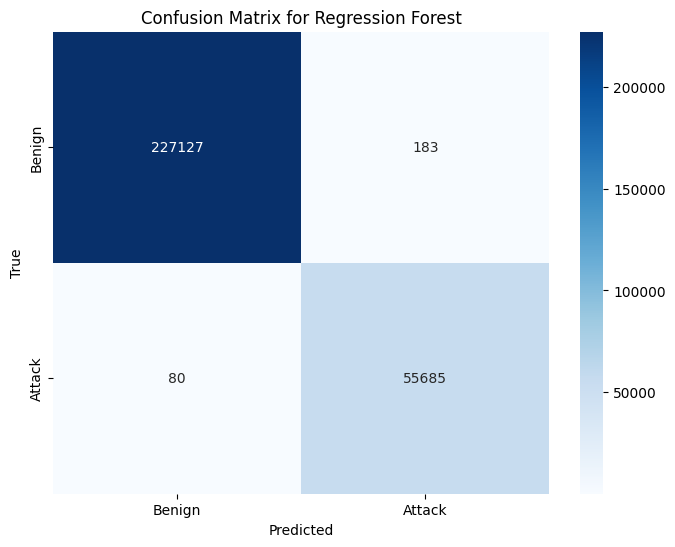

In [95]:
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, rf_model_binary.predict(scaler.transform(X_eval)))
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = rf_model_binary.predict(scaler.transform(X_test))
performance_models["rf"] = metrics_report("Test", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Regression Forest", Y_test, Y_pred)

#### Multi-class classifier

In [34]:
rf_model_multiclass = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
rf_model_multiclass.fit(scaler.transform(X_train), Y_train.label_code)
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.label_code, rf_model_multiclass.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
metrics_report("Test", Y_test.label_code, rf_model_multiclass.predict(scaler.transform(X_test)), print_avg=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Evaluation Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished
C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report (Evaluation):


C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


              precision    recall  f1-score   support

           0     0.9998    0.9988    0.9993    227310
           1     0.7057    0.9492    0.8095       197
           2     0.9998    0.9998    0.9998     12803
           3     0.9942    0.9942    0.9942      1029
           4     0.9977    0.9990    0.9984     23107
           5     0.9345    0.9855    0.9593       550
           6     0.9931    0.9914    0.9922       579
           7     1.0000    0.9975    0.9987       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    0.7500    0.8571         4
          10     0.9932    0.9997    0.9964     15893
          11     1.0000    0.9966    0.9983       589
          12     0.8347    0.6689    0.7426       151
          13     0.0000    0.0000    0.0000         2
          14     0.4536    0.6769    0.5432        65

    accuracy                         0.9985    283074
   macro avg     0.8604    0.8672    0.8593    283074
weighted avg     0.9987   

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9997    0.9988    0.9993    227310
           1     0.6935    0.9235    0.7921       196
           2     0.9998    0.9995    0.9996     12803
           3     0.9971    0.9971    0.9971      1030
           4     0.9971    0.9988    0.9979     23108
           5     0.9513    0.9945    0.9724       550
           6     0.9983    0.9948    0.9965       580
           7     1.0000    1.0000    1.0000       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    0.6667    0.8000         3
          10     0.9938    0.9996    0.9967     15893
          11     1.0000    0.9966    0.9983       590
          12     0.8142    0.6133    0.6996       150
          13     1.0000    0.5000    0.6667         2
          14     0.4200    0.6462    0.5091        65

    accuracy                         0.9985    283075
   macro avg     0.9243    0.8886    0.8950    283

Given that the dataset lacks many samples for some of the attack types, the multiclass classifier has low accuracy for several attack types. It is better to test other machine learning algorithms for binary classifiers.

### 3.2 Gradient Boost (XGB)

In [39]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize the XGBoost classifier
xgb_model_binary = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=1, n_jobs=-1)

# Define the scorer
scorer = make_scorer(precision_score)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model_binary, param_distributions=param_grid, n_iter=50,
                                   scoring=scorer, n_jobs=-1, cv=3, verbose=2, random_state=42)

# Fit the model on the training data
random_search.fit(scaler.transform(X_train), Y_train.is_attack)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Evaluation Set Performance
Classification Report (Evaluation):


C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0     0.9996    0.9991    0.9994    227310
           1     0.0025    0.7157    0.0050       197
           2     0.0000    0.0000    0.0000     12803
           3     0.0000    0.0000    0.0000      1029
           4     0.0000    0.0000    0.0000     23107
           5     0.0000    0.0000    0.0000       550
           6     0.0000    0.0000    0.0000       579
           7     0.0000    0.0000    0.0000       794
           8     0.0000    0.0000    0.0000         1
           9     0.0000    0.0000    0.0000         4
          10     0.0000    0.0000    0.0000     15893
          11     0.0000    0.0000    0.0000       589
          12     0.0000    0.0000    0.0000       151
          13     0.0000    0.0000    0.0000         2
          14     0.0000    0.0000    0.0000        65

    accuracy                         0.8028    283074
   macro avg     0.0668    0.1143    0.0670    283074
weighted avg     0.8027   

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}

Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9996    0.9991    0.9994    227310
           1     0.9962    0.9986    0.9974     55764

    accuracy                         0.9990    283074
   macro avg     0.9979    0.9988    0.9984    283074
weighted avg     0.9990    0.9990    0.9990    283074

Accuracy: 0.9989649349640023
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9996    0.9992    0.9994    227310
           1     0.9967    0.9985    0.9976     55765

    accuracy                         0.9991    283075
   macro avg     0.9982    0.9989    0.9985    283075
weighted avg     0.9991    0.9991    0.9991    283075

Accuracy: 0.9990673849686479


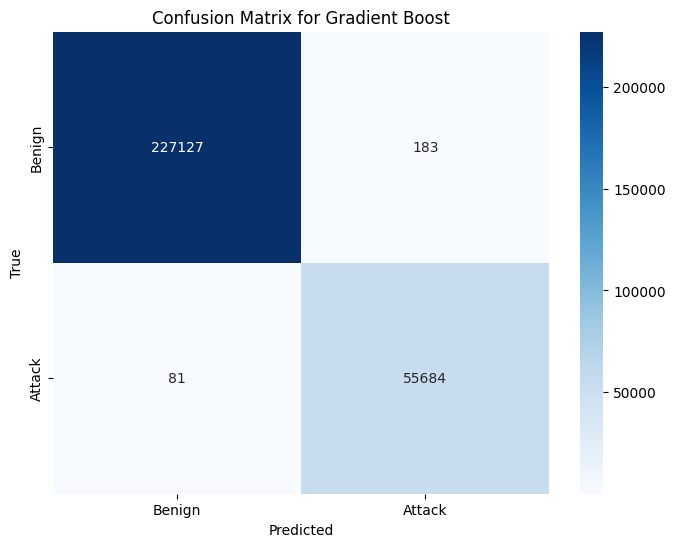

In [98]:
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_xgb_model.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_xgb_model.predict(scaler.transform(X_test))
performance_models["xgb"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("Gradient Boost", Y_test, Y_pred)


### 3.3 ADABoost

In [61]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost_model = AdaBoostClassifier(
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Learning rate (contribution of each weak learner)
    algorithm='SAMME',  # SAMME.R is recommended for probability estimates
    random_state=42
)

# Fit the model on the training data
ada_boost_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9881    0.9911    0.9896    227310
           1     0.9632    0.9515    0.9573     55764

    accuracy                         0.9833    283074
   macro avg     0.9757    0.9713    0.9735    283074
weighted avg     0.9832    0.9833    0.9832    283074

Accuracy: 0.9832799903912052
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9877    0.9910    0.9894    227310
           1     0.9630    0.9498    0.9564     55765

    accuracy                         0.9829    283075
   macro avg     0.9754    0.9704    0.9729    283075
weighted avg     0.9829    0.9829    0.9829    283075

Accuracy: 0.9829267861874061


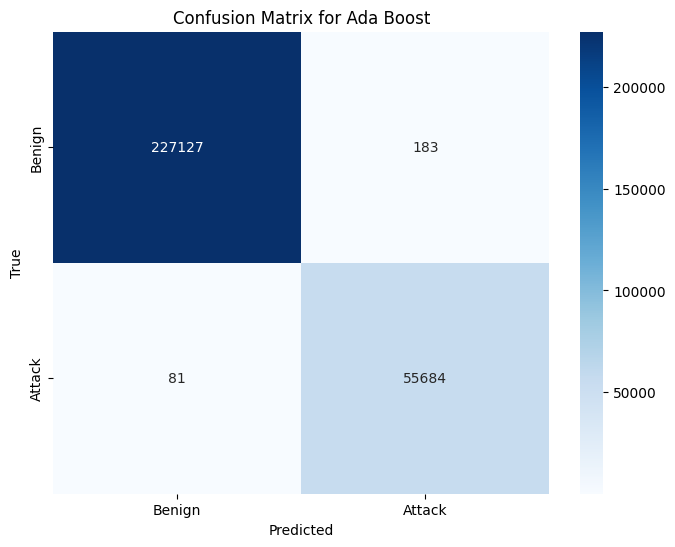

In [99]:
# Predict and evaluate on the evaluation set
y_pred_eval = ada_boost_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = ada_boost_model.predict(scaler.transform(X_test))
performance_models["adaboost"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("Ada Boost", Y_test, Y_pred)

### 3.4 ID3

In [65]:
id3_model = DecisionTreeClassifier(
    criterion='entropy',  # Use entropy for ID3-like behavior
    max_depth=None,  # Unlimited depth (ID3 doesn't prune trees)
    random_state=42
)

# Fit the model on the training data
id3_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9996    0.9989    0.9993    227310
           1     0.9957    0.9984    0.9971     55764

    accuracy                         0.9988    283074
   macro avg     0.9977    0.9987    0.9982    283074
weighted avg     0.9989    0.9988    0.9988    283074

Accuracy: 0.9988483576732586
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9996    0.9991    0.9993    227310
           1     0.9963    0.9983    0.9973     55765

    accuracy                         0.9990    283075
   macro avg     0.9980    0.9987    0.9983    283075
weighted avg     0.9990    0.9990    0.9990    283075

Accuracy: 0.9989508080897289


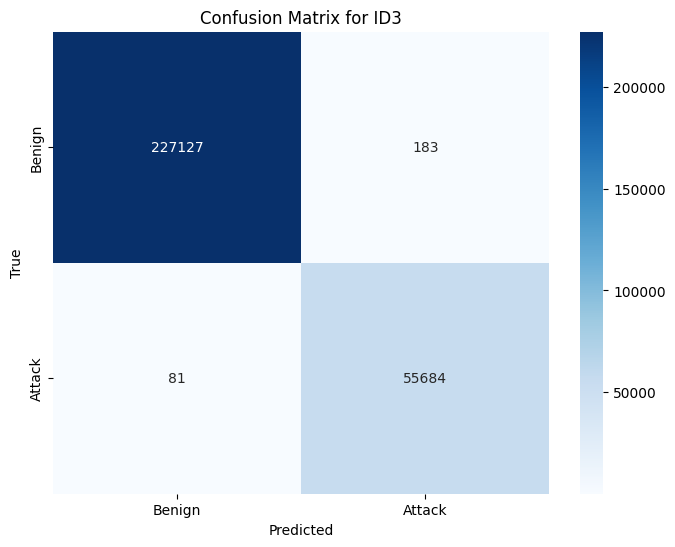

In [100]:
y_pred_eval = id3_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = id3_model.predict(scaler.transform(X_test))
performance_models["id3"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("ID3", Y_test, Y_pred)

### Conclusion

{'rf': {'0': {'precision': 0.9996478981721514, 'recall': 0.9991949320311468, 'f1-score': 0.9994213637773725, 'support': 227310.0}, '1': {'precision': 0.9967244218515071, 'recall': 0.9985654084102932, 'f1-score': 0.9976440658228302, 'support': 55765.0}, 'accuracy': 0.9990709176013424, 'macro avg': {'precision': 0.9981861600118292, 'recall': 0.99888017022072, 'f1-score': 0.9985327148001013, 'support': 283075.0}, 'weighted avg': {'precision': 0.9990719813408498, 'recall': 0.9990709176013424, 'f1-score': 0.9990712409461969, 'support': 283075.0}}, 'xgb': {'0': {'precision': 0.9996434984683638, 'recall': 0.9991949320311468, 'f1-score': 0.999419164917561, 'support': 227310.0}, '1': {'precision': 0.9967243632197899, 'recall': 0.9985474760154218, 'f1-score': 0.9976350867134872, 'support': 55765.0}, 'accuracy': 0.9990673849686479, 'macro avg': {'precision': 0.9981839308440767, 'recall': 0.9988712040232843, 'f1-score': 0.9985271258155242, 'support': 283075.0}, 'weighted avg': {'precision': 0.9990

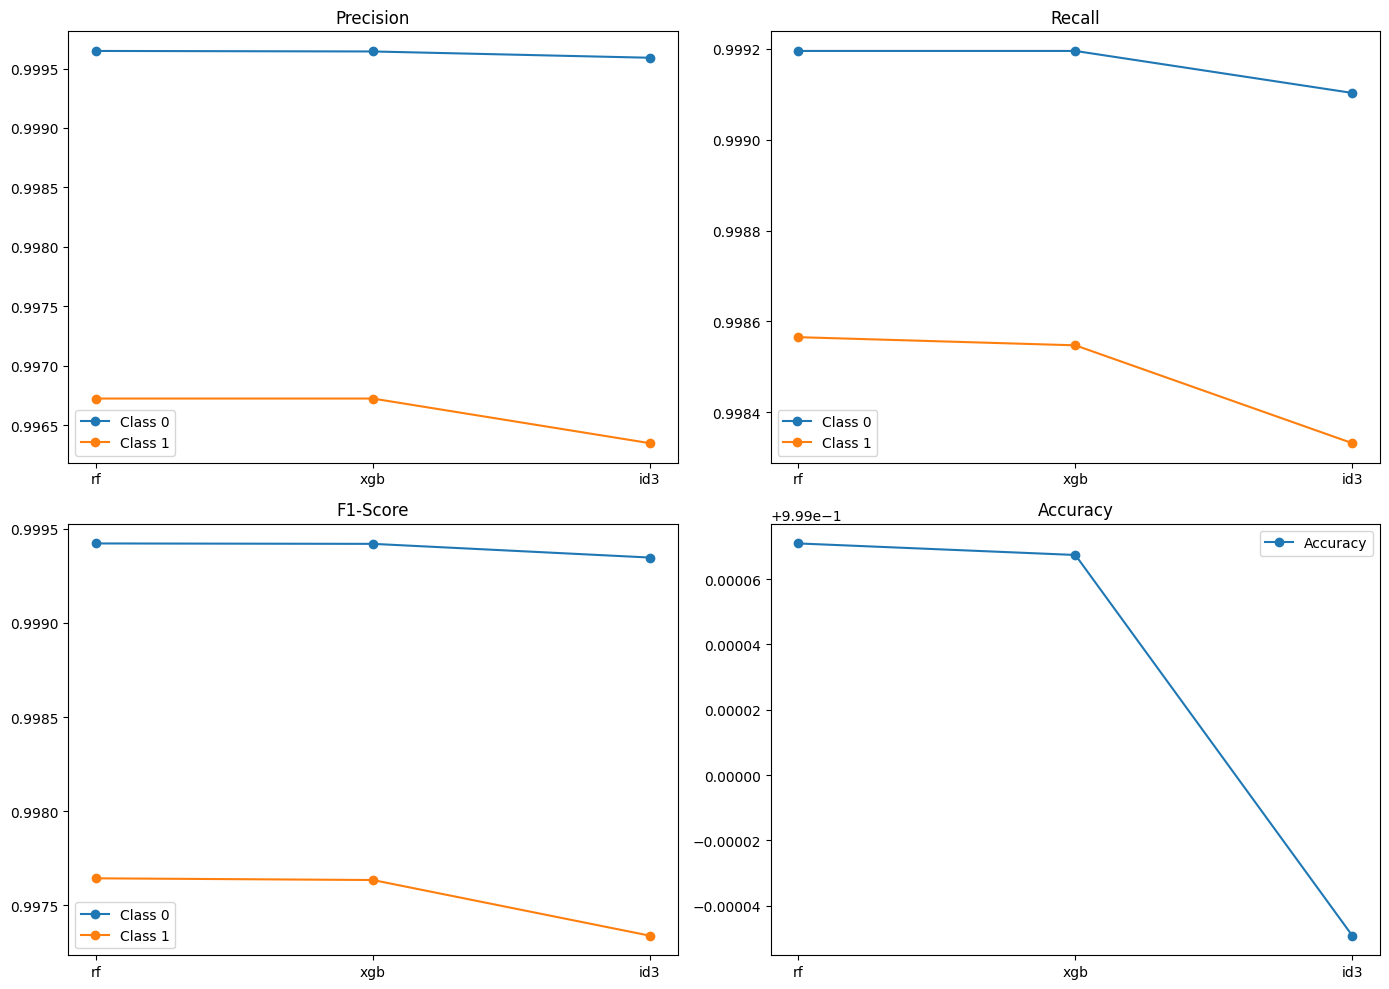

In [121]:
def extract_and_plot_metrics(metrics_dict):
    # Initialize dictionaries to store the metrics for plotting
    precision_dict = {'0': [], '1': [], 'model': []}
    recall_dict = {'0': [], '1': [], 'model': []}
    f1_score_dict = {'0': [], '1': [], 'model': []}
    accuracy_list = []

    # Iterate over the models in the metrics dictionary
    for model_name, metrics in metrics_dict.items():
        precision_dict['0'].append(metrics['0']['precision'])
        precision_dict['1'].append(metrics['1']['precision'])
        recall_dict['0'].append(metrics['0']['recall'])
        recall_dict['1'].append(metrics['1']['recall'])
        f1_score_dict['0'].append(metrics['0']['f1-score'])
        f1_score_dict['1'].append(metrics['1']['f1-score'])
        accuracy_list.append(metrics['accuracy'])
        precision_dict['model'].append(model_name)
        recall_dict['model'].append(model_name)
        f1_score_dict['model'].append(model_name)
        
    # Plotting the metrics
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot precision
    axs[0, 0].plot(precision_dict['model'], precision_dict['0'], label='Class 0', marker='o')
    axs[0, 0].plot(precision_dict['model'], precision_dict['1'], label='Class 1', marker='o')
    axs[0, 0].set_title('Precision')
    axs[0, 0].legend()
    
    # Plot recall
    axs[0, 1].plot(recall_dict['model'], recall_dict['0'], label='Class 0', marker='o')
    axs[0, 1].plot(recall_dict['model'], recall_dict['1'], label='Class 1', marker='o')
    axs[0, 1].set_title('Recall')
    axs[0, 1].legend()
    
    # Plot f1-score
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['0'], label='Class 0', marker='o')
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['1'], label='Class 1', marker='o')
    axs[1, 0].set_title('F1-Score')
    axs[1, 0].legend()
    
    # Plot accuracy
    print(accuracy_list)
    print(precision_dict['model'])
    axs[1, 1].plot(precision_dict['model'], accuracy_list, label='Accuracy', marker='o')
    axs[1, 1].set_title('Accuracy')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
#extract_and_plot_metrics(performance_models)
performance_models2 = performance_models.copy()
performance_models2.pop("adaboost")
print(performance_models2)
extract_and_plot_metrics(performance_models2)

XGBoost and Random Forest perform very well on the dataset while Adaboost is the worse model of the 3. To conclude, after finetuning the hyperparameters, random forest seems to be the best tree based algorithm to perform on the dataset.